# KSA: Polar Observations and Modelling

# Week 7 - The effect of meltwater

Last class we have looked at a model simulation of future changes that did not account for changes in Antarctic Ice Sheet melt. This class we will look at the second simulation from [Dawson et al (2024)] for the SSP585 scenario, the one that has meltwater projections included (purple line below):

<div align="center",style="max-width: 500px;">
    <img src="images/sim_schematic.png" width="60%" />
</div>

This is a very interesting simulation because the effects of meltwater are one of the most poorly constrained processes in the Southern Ocean - which means we don't fully know how it works, its magnitude, and what type of changes we can expect. Meltwater from ice sheets comes is formed, primarily, in ice sheet cavities (the left side of the schematic below from [Bennets et al. (2024)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022RG000781):

<div align="center",style="max-width: 500px;">
    <img src="images/schematic.png" width="40%" />
</div>

The processes at the cavities are very complex and occure at very small spatial scales, so their effect in ocean models is usually parametrised. However, this is rare: most ocean models don't even have an ice sheet interaction parametrisation. They just dump freshwater at the surface, around the coastline. This is way meltwater currently contributes a large uncertainty within future projections. More on this topic can be read in [Golledge et al. (2019)](https://www.nature.com/articles/s41586-019-0889-9), which is were the estimates of future melt for the simulations we'll see now were obtained from.  

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Load experiment data

Same as previous class, except this time the meltwater experiments start with `mw_ssp5485_8`:

In [3]:
path_ctrl = glob.glob('data/control*.nc') 
control = xr.open_mfdataset(path_ctrl, chunks = 'auto')

In [4]:
path_pert = glob.glob('data/mw_ssp585*.nc') 
exp_585_mw = xr.open_mfdataset(path_pert, chunks = 'auto')

## Changes to temperature and salinity

Same as previous class, let's calculate the anomalies of the perturbation experiment with respect to control:

In [5]:
temp_anom = exp_585_mw['temp'] - control['temp']
salt_anom = exp_585_mw['salt'] - control['salt']

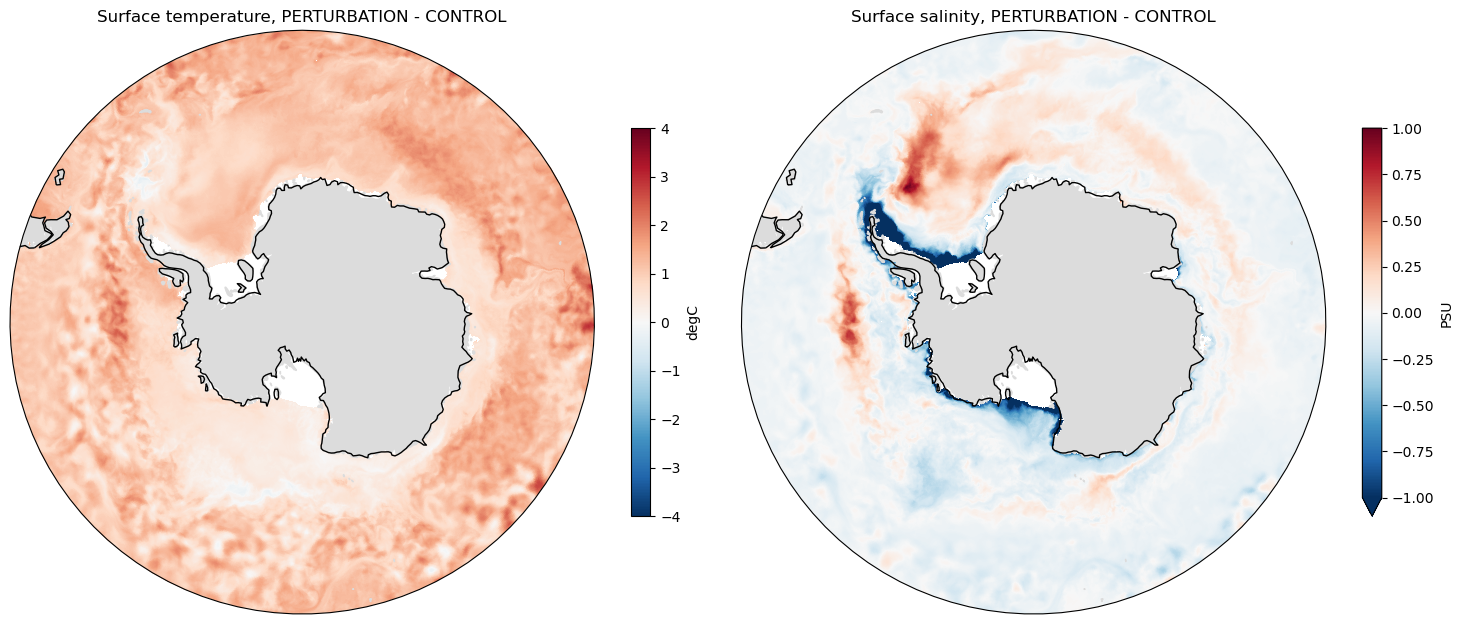

In [6]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

temp_anom.sel(st_ocean = 0, method = 'nearest').plot(ax = axs[0], cmap = 'RdBu_r', vmin = -4, vmax = 4,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Surface temperature, PERTURBATION - CONTROL');

salt_anom.sel(st_ocean = 0, method = 'nearest').plot(ax = axs[1], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Surface salinity, PERTURBATION - CONTROL');

plt.tight_layout();

If you compare with the plots from the previous class, we are getting similar patterns of change but of lesser magnitude for SST, and increased magnitude for SSS. 

Now let's calculate bottom temperature and salinities. Changes in the bottom are slower to appear, since they are communicated via a density-driven circulation that is very slow (the abyssal cell of the MOC), so we don't expect changes in the bottom layer to be as large in magnitude as in the surface.

In [7]:
mask = xr.where(np.isnan(control['temp']), 0, 1)
mask = mask.cumsum('st_ocean')
bottom_level = mask.argmax('st_ocean')

In [8]:
bottom_level = bottom_level.compute()

In [9]:
temp_anom_b = temp_anom.isel(st_ocean = bottom_level)
salt_anom_b = salt_anom.isel(st_ocean = bottom_level)

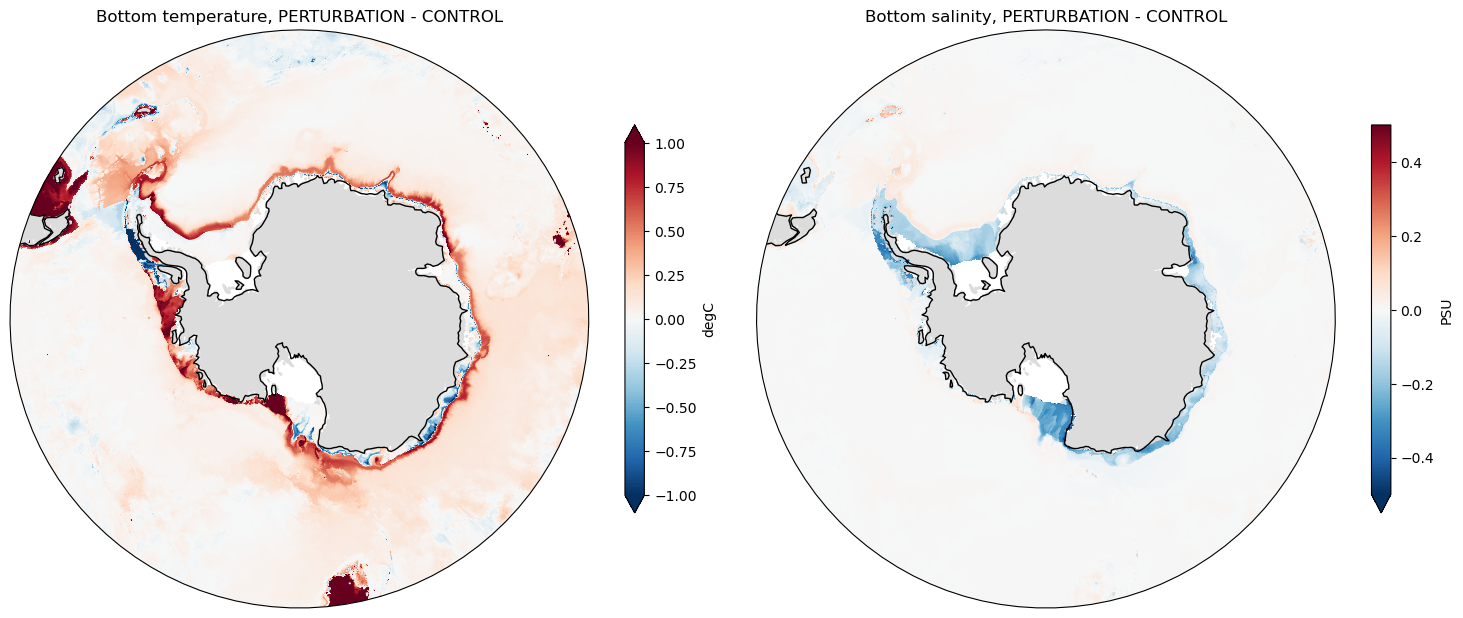

In [10]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

temp_anom_b.plot(ax = axs[0], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Bottom temperature, PERTURBATION - CONTROL');

salt_anom_b.plot(ax = axs[1], cmap = 'RdBu_r', vmin = -.5, vmax = .5,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Bottom salinity, PERTURBATION - CONTROL');

plt.tight_layout();

## Changes to Drake Passage transport

Let's calculate the transport streamfunction, and calculate the Drake Passage transport for the control simulation and the perturbation. Remember that this is a way to monitor changes to the Antarctic Circumpolar Current strength.

In [11]:
T_control = control['tx_trans_int_z']/(1035*1e6)
T_exp_585_mw = exp_585_mw['tx_trans_int_z']/(1035*1e6)

ψ_control = T_control.cumsum('yt_ocean')
ψ_exp_585_mw = T_exp_585_mw.cumsum('yt_ocean')

In [12]:
ψ_south_america = ψ_control.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ_control.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')
DP_transport_control = ψ_south_america - ψ_antarctic_pen

ψ_south_america = ψ_exp_585_mw.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ_exp_585_mw.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')
DP_transport_exp_585_mw = ψ_south_america - ψ_antarctic_pen

In [13]:
DP_transport_control.values

array(138.24509, dtype=float32)

In [14]:
DP_transport_exp_585_mw.values

array(121.53233, dtype=float32)

## Changes to the MOC

Let's calculate changes to the strength of the MOC. 

In [15]:
Ty_rho = control['ty_trans_rho'] / (1035*1e6)
Ty_rho_int_x = Ty_rho.sum('grid_xt_ocean')
ψ_rho_control = Ty_rho_int_x.cumsum('potrho') 

Ty_rho = exp_585_mw['ty_trans_rho'] / (1035*1e6)
Ty_rho_int_x = Ty_rho.sum('grid_xt_ocean')
ψ_rho_exp_585_mw = Ty_rho_int_x.cumsum('potrho') 

In [16]:
levels =  np.hstack((np.arange(-35, 0, 4), np.flip(-np.arange(-35, 0, 4))))
cbarticks = np.hstack((np.flip(-np.arange(3, 35, 6)), np.arange(3, 35, 6)))

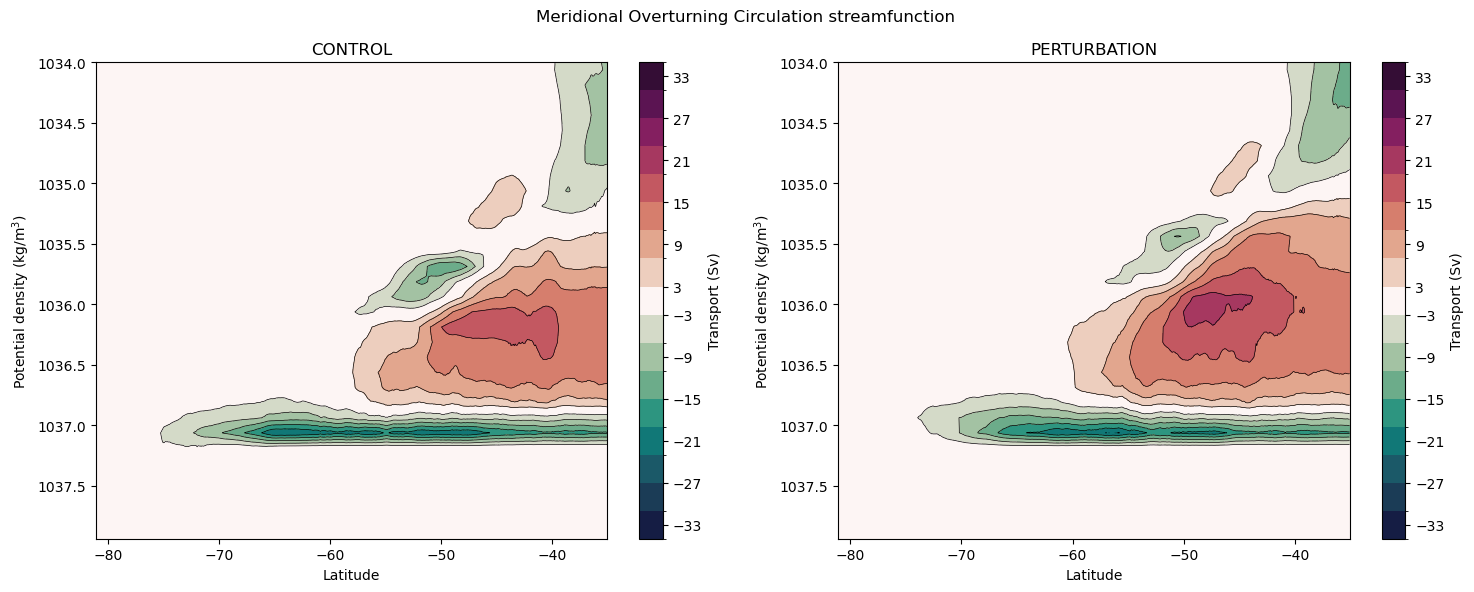

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))
ψ_rho_control.plot.contourf(ax = axs[0], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho_control.plot.contour(ax = axs[0], levels = levels, colors = ['k'], linewidths = [0.5])
axs[0].set_title('CONTROL');
axs[0].set_ylabel('Potential density (kg/m$^3$)')
ψ_rho_exp_585_mw.plot.contourf(ax = axs[1], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho_exp_585_mw.plot.contour(ax = axs[1], levels = levels, colors = ['k'], linewidths = [0.5])
axs[1].set_ylabel('Potential density (kg/m$^3$)')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.set_xlabel('Latitude');
    ax.invert_yaxis();
    ax.set_ylim(None, 1034);
fig.suptitle('Meridional Overturning Circulation streamfunction');
plt.tight_layout();

In [18]:
MOC_strength_control = ψ_rho_control.sel(potrho = slice(None, 1036)).min().values
MOC_strength_exp_585_mw = ψ_rho_exp_585_mw.sel(potrho = slice(None, 1036)).min().values

In [19]:
MOC_strength_control

array(-14.793337, dtype=float32)

In [20]:
MOC_strength_exp_585_mw

array(-12.347183, dtype=float32)

## Antarctic Slope Current changes

In [21]:
asc_fresh_c = control['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')
asc_fresh_p = exp_585_mw['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')

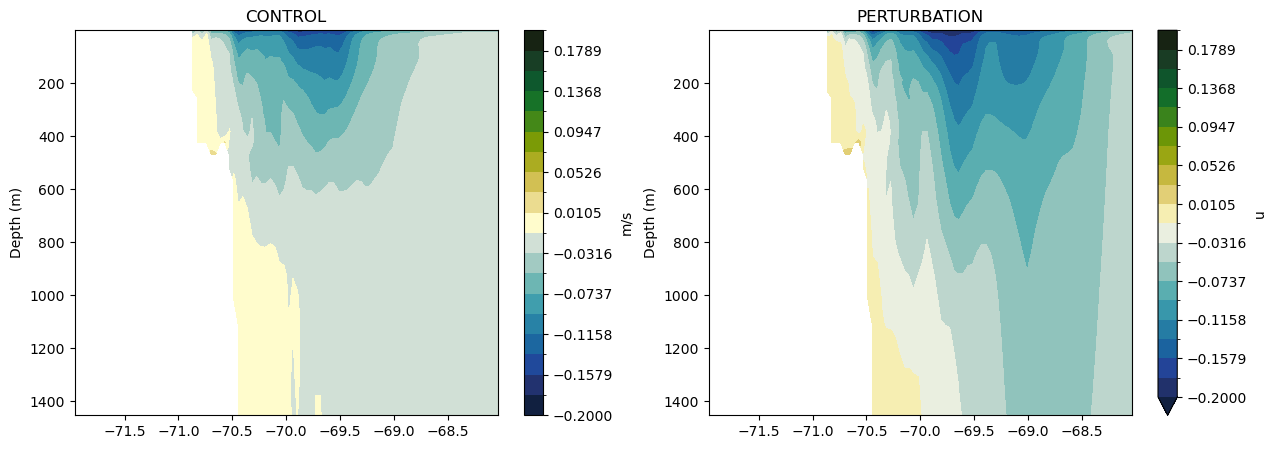

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_fresh_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_fresh_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta)
axs[0].set_title('CONTROL')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

In [23]:
asc_dense_c = control['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')
asc_dense_p = exp_585_mw['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')

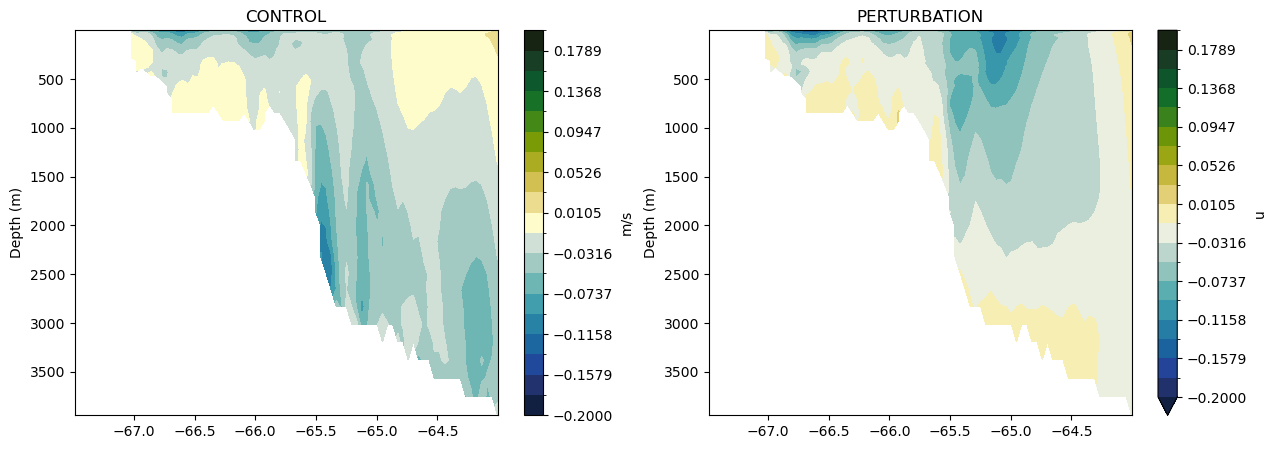

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_dense_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_dense_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.2, vmax = .2, cmap = cm.cm.delta)
axs[0].set_title('CONTROL')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

In [25]:
asc_warm_c = control['u'].sel(xu_ocean = slice(-100, -90), yu_ocean = slice(-72, -68), st_ocean = slice(None, 4000)).mean('xu_ocean')
asc_warm_p = exp_585_mw['u'].sel(xu_ocean = slice(-100, -90), yu_ocean = slice(-72, -68), st_ocean = slice(None, 4000)).mean('xu_ocean')

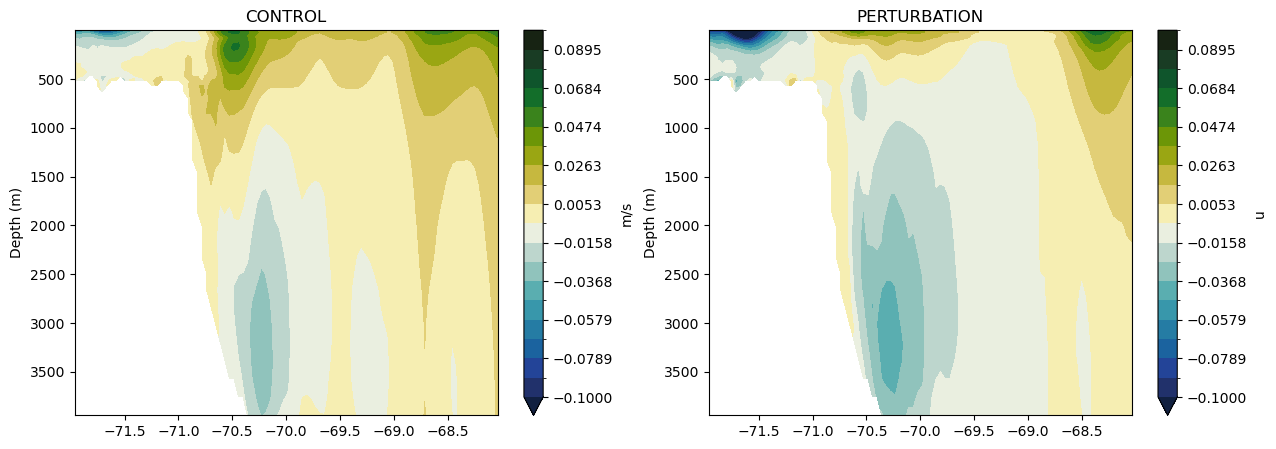

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_warm_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.1, vmax = .1, cmap = cm.cm.delta,
                          cbar_kwargs = {'label':'m/s'})
asc_warm_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.1, vmax = .1, cmap = cm.cm.delta)
axs[0].set_title('CONTROL')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

<h4 style="color: red;">Question 1</h4>

Using the figures from last class, discuss the changes that you observe in these simulations. How do they differ/not differ from the simulations without meltwater?

*Answer here*